# Imports et setup technique

In [1]:
import pandas as pd
from IPython.display import display
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
from pathlib import Path
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.models.annotations import BoxAnnotation
from bokeh.models.widgets import DateRangeSlider, Select, DatePicker
from bokeh.layouts import row, column
from bokeh.models.formatters import NumeralTickFormatter

from functools import partial
from datetime import datetime, date
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
from scripts.utils import compute_zscores, process_df, compute_distribution
import scripts.utils as utils

Loading BokehJS ...

# Chargement des données

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
    'export2BRE_clt.csv',
    'exportcomp1ALO.csv',
]
paths = [Path('..') / 'data' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

client  V groupecompte                                  nom  \
46158  3002903  A         ZCOL               PERSO MAISON FAMILIALE   
22857  5000312  A         ZCFR                       DLG 3BRASSEURS   
12096   119119  A         ZCLT                REST S'MUNSTERSTUEWEL   
7940     64040  A         ZCRC                    BARBOTEU LE GAUDI   
2376     15517  A         ZHIE  LE CEDRE FOND AUTEUIL PAYS DE LOIRE   

      postalcode seg1 seg2 seg3 seg4  cat  ... grpclt5  agence condexp  \
46158      13310   Z4   Z0   ZQ   ZO   Z5  ...     051    1AVI      ST   
22857      94310  NaN  NaN  NaN  NaN  NaN  ...     NaN     NaN      EN   
12096      67000   Z3   Z5   ZK   ZG   ZS  ...     051    1STR      ST   
7940       66100   Z3   Z5   ZK   ZG   ZS  ...     051    1NIM      ST   
2376       71600  NaN  NaN  NaN  NaN  NaN  ...     NaN     NaN     NaN   

       pricetype relationtype pilcom  hier4  hier3  hier2  hier1  
46158        NaN          NDI    RGL    NaN    NaN    NaN    NaN  
22857        NaN          NaN    NaN    NaN    NaN    NaN    NaN  
12096         T1          NDI    RGL    NaN    NaN    NaN    NaN  
7940         NaN          DIR    RGL  54311  54312  54313  54314  
2376         NaN          NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 31 columns]

In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 104640
Duplicated clients before cleansing: 4634
Clients count after cleansing : 102323
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

V groupecompte                     nom postalcode seg1  \
orgacom client                                                               
1ALO    0003001353  A         ZCOL  PERSO 402 ORDINAIRE RA      51000   Z4   
2BRE    P023188     A         ZPER          LE BAIL GAETAN      35136   Z4   
1SOU    0000111859  A         ZCLT   RESTAURANT L ORCHIDEE      17800   Z3   
1LRO    0000266273  A         ZHIE               FEELNFOOD      75009  NaN   
1SOU    0000232793  A         ZCLT          CENTRAL HOSTEL      33000   Z3   

                   seg2 seg3 seg4  cat sscat  ...  grpclt5 agence  condexp  \
orgacom client                                ...                            
1ALO    0003001353   Z0   ZQ   ZO   Z5   Z27  ...      050   1REI       ST   
2BRE    P023188      Z0   ZQ   ZO   Z5   Z27  ...      010   2REN       EN   
1SOU    0000111859   Z5   ZK   ZG   ZS    ZK  ...      051   1RCH       ST   
1LRO    0000266273  NaN  NaN  NaN  NaN   NaN  ...      NaN    NaN      NaN   
1SOU    0000232793   Z5   ZK   ZG   ZT    ZK  ...      051   1BDX       ST   

                   pricetype relationtype pilcom  hier4  hier3  hier2  hier1  
orgacom client                                                                
1ALO    0003001353        T1          NDI    RGL    NaN    NaN    NaN    NaN  
2BRE    P023188          NaN          DIR    RGL  11241  11242  80355  80356  
1SOU    0000111859        T2          NDI    RGL    NaN    NaN    NaN    NaN  
1LRO    0000266273       NaN          NaN    NaN    NaN    NaN    NaN    NaN  
1SOU    0000232793        T2          NDI    RGL    NaN    NaN    NaN    NaN  

[5 rows x 29 columns]

In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD ZCAB


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                     
1     Z1           Distribution
      Z3                    RHD
      Z4                 Divers
2     Z0      Autres clientèles
      Z1                    GMS
...                         ...
6     ZI    Police Pomp Gendarm
      ZJ    Gastro -semi gastro
      ZK          Moyenne gamme
      ZL             Economique
      ZM    Petit déj. exclusif

[136 rows x 1 columns]

## Historiques de vente

In [8]:
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path_list = [Path('..') / 'data' / filename for filename in ['EXTRACT_LIGNES_VENTES_V3.csv',
                                                             'EXTRACTION_2BRE.csv']]
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [9]:
data = [pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  ) for path in path_list]
data = pd.concat(data, axis=0)
data.sample(5)

orgacom   month    week       date pricetype      client doctype  \
4052072     2BRE  201903  201911 2019-03-12      ZTCE  0000167699    ZC10   
29659970    1ALO  202005  202022 2020-05-25      ZTCE  0000027574    ZC10   
19519059    1SOU  201904  201918 2019-04-30      ZTCE  0000184942    ZC10   
30191247    1ALO  202006  202025 2020-06-17      ZTCE  0000025017    ZC10   
29128596    1SOU  202003  202013 2020-03-27      ZTCE  0000218029    ZC10   

         origin salesgroup            material  brutrevenue brutrevcur  \
4052072     EDI        A17  000000000000019854         4.07        EUR   
29659970    EDI        608  000000000000087859        12.60        EUR   
19519059    EDI        802  000000000000196476        18.48        EUR   
30191247    EDI        632  000000000000196648        25.54        EUR   
29128596    EDI        806  000000000000033568         0.00        EUR   

          netrevenue netrevcur  weight weightunit  margin margincur  \
4052072         3.47       EUR   3.030         KG    1.04       EUR   
29659970       11.73       EUR  10.000         KG    2.37       EUR   
19519059       15.04       EUR   2.399         KG    0.30       EUR   
30191247       17.52       EUR   4.544         KG    8.63       EUR   
29128596        0.16       EUR   0.000         KG    0.16       EUR   

          marginperkg  
4052072          0.34  
29659970         0.24  
19519059         0.13  
30191247         1.90  
29128596         0.00

## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [10]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [11]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [12]:
order_doctype_mask = data.doctype.isin(valid_doctypes)

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [13]:
if len(data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446', 'FC42378', '000000000000156486',
       'FC34504', 'FC34502', 'FC34503'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [14]:
if len(data.loc[order_doctype_mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

## Calcul des indicateurs manquants

In [15]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Définition des formats des indicateurs

In [113]:
formats = utils.formats

## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

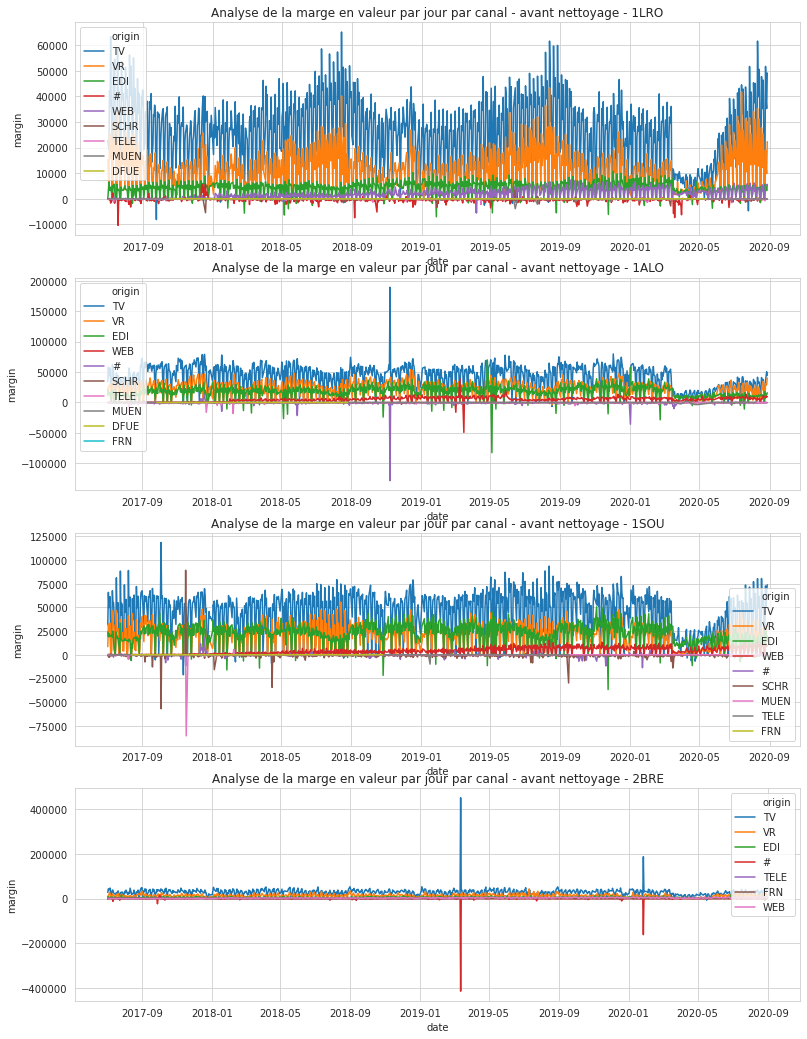

In [17]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1)
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [18]:
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [19]:
%%time
dfs = []
for suc in data.orgacom.unique():
    print(f'Début du traitement pour {suc}')
    to_process = data.loc[data.orgacom == suc]
    data = data.loc[data.orgacom != suc]
    dfs.append(process_df(to_process))

Début du traitement pour 1LRO
Evolution des indicateurs pendant le traitement : 
margin        -9.685755e-08
brutrevenue   -2.384186e-07
weight        -1.490116e-08
dtype: float64
Début du traitement pour 1ALO
Evolution des indicateurs pendant le traitement : 
margin        -7.450581e-07
brutrevenue    1.192093e-07
weight         7.450581e-08
dtype: float64
Début du traitement pour 1SOU
Evolution des indicateurs pendant le traitement : 
margin        -1.490116e-08
brutrevenue   -1.549721e-06
weight         1.341105e-07
dtype: float64
Début du traitement pour 2BRE
Evolution des indicateurs pendant le traitement : 
margin         2.086163e-07
brutrevenue   -1.788139e-07
weight         4.470348e-08
dtype: float64
CPU times: user 5min 12s, sys: 1min 26s, total: 6min 38s
Wall time: 6min 38s


In [20]:
data = pd.concat(dfs, axis=0)
del(dfs)
data.sample(10)

orgacom   month    week       date pricetype      client doctype  \
354804      1LRO  201708  201734 2017-08-21      ZTCR  0000161964    ZC10   
9108661     1ALO  201909  201936 2019-09-08      ZTCE  0000215930    ZC10   
11884300    1SOU  202003  202011 2020-03-13      ZTCE  0000069967    ZC10   
10426429    1ALO  201912  201952 2019-12-27      ZTCE  0000128692    ZC10   
5845416     1SOU  201810  201843 2018-10-23      ZTCE  0000235606    ZC10   
9522475     1SOU  201908  201935 2019-08-28      ZTCE  0000070463    ZC10   
10547544    1SOU  201911  201946 2019-11-17      ZTCE  0000259814    ZC10   
12076059    1ALO  202007  202029 2020-07-15      ZTCE  0000023603    ZC10   
9386625     1ALO  201909  201940 2019-09-30       ZTG  0000020567    ZC10   
6796831     2BRE  202005  202020 2020-05-17      ZTCE  0000154596    ZC10   

         origin salesgroup            material  ... margincur  marginperkg  \
354804       TV        748  000000000000021359  ...       EUR         2.13   
9108661     EDI        590  000000000000196109  ...       EUR         0.00   
11884300    EDI        782  000000000000022147  ...       EUR         1.31   
10426429    EDI        H27  000000000000085033  ...       EUR        -0.37   
5845416      TV        782  000000000000185045  ...       EUR         1.49   
9522475     EDI        801  000000000000190510  ...       EUR        -0.61   
10547544    EDI        801  000000000000156052  ...       EUR         0.00   
12076059    EDI        H30  000000000000059904  ...       EUR         0.18   
9386625      TV        H14  000000000000067213  ...       EUR        11.12   
6796831     EDI        A22  000000000000043880  ...       EUR         0.00   

         purchcost purchcostperkg       PMVK  marginpercent  _duplicated  \
354804       35.55       3.555000   5.680000       0.374120        False   
9108661       0.02            inf        NaN            NaN        False   
11884300     24.14       8.746377  10.057971       0.130403        False   
10426429     38.15       7.376257   7.008894      -0.052414        False   
5845416      12.58       6.621053   8.115789       0.184176        False   
9522475      19.12       3.186667   2.578333      -0.235941        False   
10547544      0.06            inf        NaN            NaN         True   
12076059     59.88       3.696296   3.877778       0.046800        False   
9386625     136.40      13.623652  24.747303       0.449489        False   
6796831      -2.25           -inf        NaN            NaN        False   

          margin  brutrevenue  weight  
354804     21.25        56.80  10.000  
9108661    -0.02         0.00   0.000  
11884300    3.62        27.76   2.760  
10426429   -1.90        36.25   5.172  
5845416     2.84        15.42   1.900  
9522475    -3.65        15.47   6.000  
10547544   -0.06         0.00   0.000  
12076059    2.94        62.82  16.200  
9386625   111.37       247.77  10.012  
6796831     2.25         0.00   0.000  

[10 rows x 24 columns]

On peut plotter les indicateurs après nettoyage :

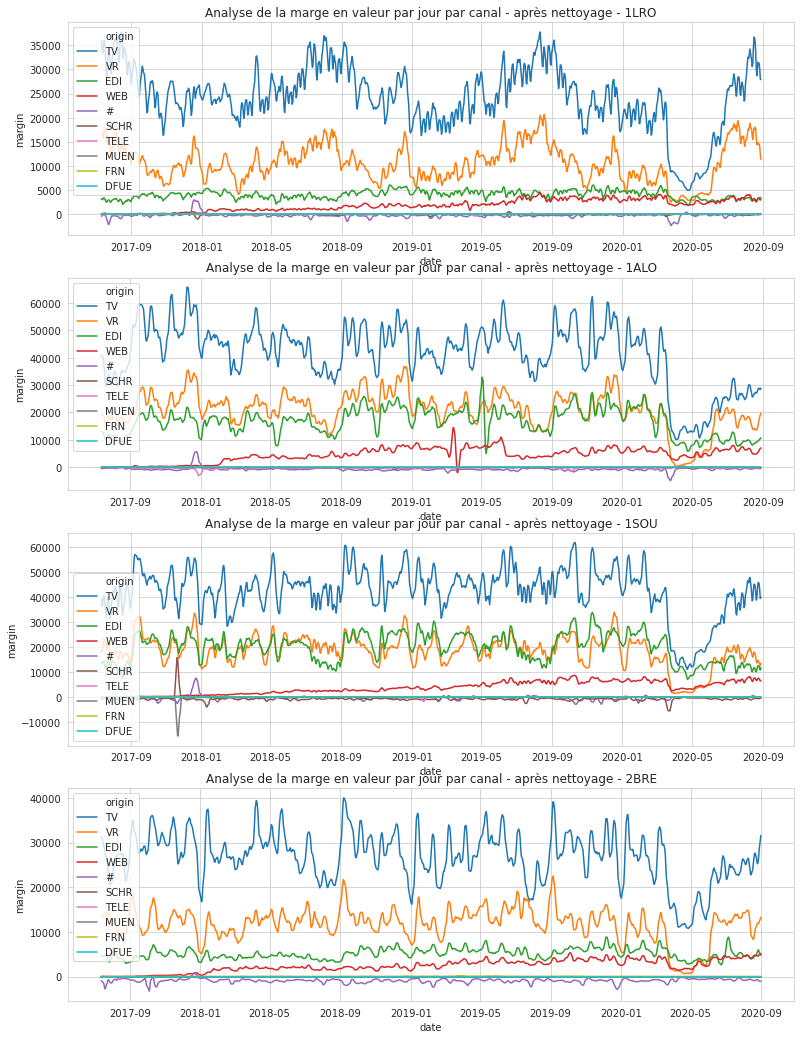

In [21]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(10, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage - {orgacoms[i]}')


## Affichage des indicateurs par succursale et canal

In [22]:
indicator_map = {
    'Marge (€)': 'margin',
    'CA brut (€)': 'brutrevenue',
    'Tonnage (kg)': 'weight',
}

CPU times: user 24.4 s, sys: 8.08 s, total: 32.5 s
Wall time: 32.3 s


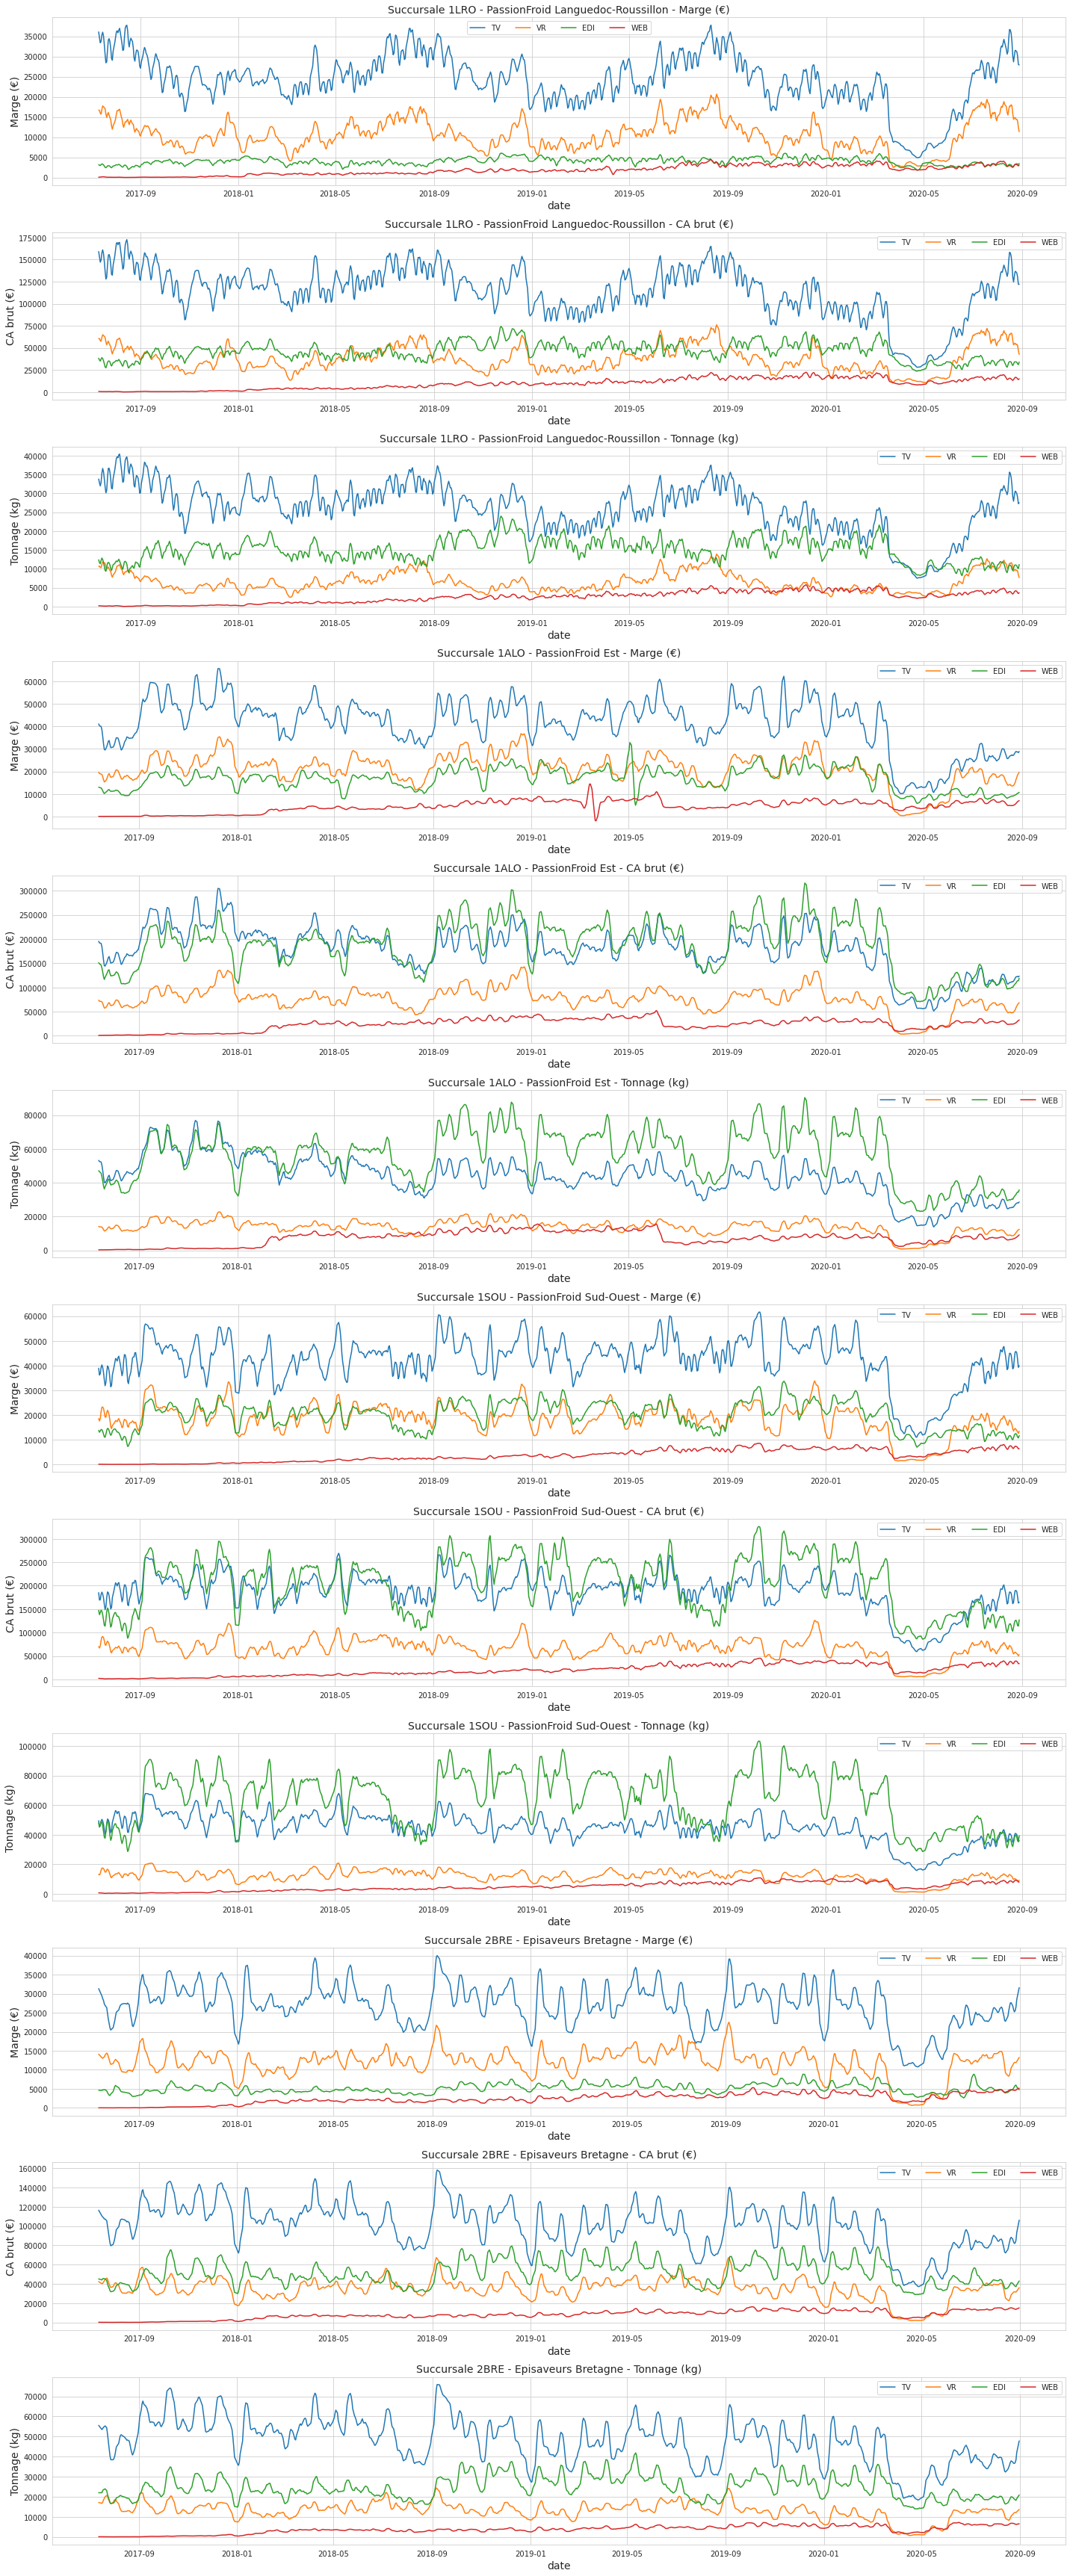

In [23]:
%%time
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)* len(indicator_map)),
                        nrows=len(SV) * len(indicator_map),
#                         squeeze=False,
                       )

for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicator_map):
        
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator_map[indicator]]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot, x='date', y=indicator, hue='origin', ax=axs[i * len(indicator_map) + j])
        handles, labels = axs[i * len(indicator_map) + j].get_legend_handles_labels()
        handles = handles[1:]
        labels = labels[1:]
        axs[i * len(indicator_map) + j].legend(handles, labels, ncol=4, )
        axs[i * len(indicator_map) + j].set_title(f'Succursale {utils.lib(suc)} - {indicator}', fontsize=14)
        axs[i * len(indicator_map) + j].xaxis.label.set_fontsize(14)
        axs[i * len(indicator_map) + j].yaxis.label.set_fontsize(14)
        
fig.tight_layout()

## Filtration des canaux "exotiques"

In [24]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
data['origin2'] = data.origin.astype(origin2_cat)

## Calcul du canal majoritaire par jour

In [25]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2751677 records in order dataframe before canal deduplication


margin  brutrevenue   weight  linecount
orgacom date       client     origin2                                         
1SOU    2017-07-03 0000065940 TV        31.16        84.01    5.501          9
                   0000065945 TV         6.02        23.69    3.734          2
                   0000065975 TV        25.15        97.40   13.718          1
                   0000065998 TV         4.12         8.56    1.000          1
                   0000066014 TV        17.89        48.30    5.000          1
...                                       ...          ...      ...        ...
2BRE    2020-08-31 0000285226 VR         1.38        10.16   10.000          2
                   SL001W     TV        89.34       555.25  180.000          4
                   SL0041     TV        28.42      1470.00    7.200          1
                   SL0075     TV        12.76        95.03   15.615         11
                   SL009N     TV        10.51        75.03   40.500          1

[2751677 rows x 4 columns]

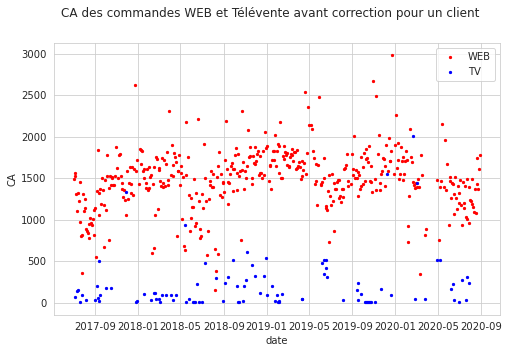

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color='red',
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color='blue',
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('date')
ax.set_ylabel('CA')
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client')
ax.legend()


On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [27]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
2BRE     2020-08-31  0000282373    EDI
                     0000283953    EDI
                     0000284089     TV
                     0000284540     TV
                     0000284735     VR
Name: origin2, Length: 2444326, dtype: object

In [28]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
order_count = len(orders)
print(f'{order_count} records in order dataframe after canal deduplication')
orders

2444326 records in order dataframe after canal deduplication


margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

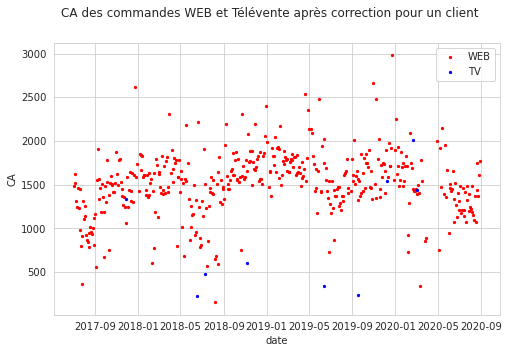

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color='red',
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color='blue',
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('date')
ax.set_ylabel('CA')
fig.suptitle('CA des commandes WEB et Télévente après correction pour un client')
ax.legend()


## Ajout de la segmentation et de la hiérarchie

On ajoute quelques données du dataset client.

In [30]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')
if len(orders) != order_count:
    raise RuntimeError('Something went wrong when merging orders with client master data!')

In [31]:
orders

margin  brutrevenue   weight  linecount  \
orgacom date       client                                                
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9   
        2017-08-28 0000065940   44.36       105.93    8.048         10   
        2017-09-08 0000065940   17.60        40.35    3.000          2   
        2017-09-15 0000065940  100.12       236.77   20.312          3   
        2017-09-25 0000065940   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    2020-08-31 0000282373  177.42      1401.58  488.036         88   
                   0000283953   43.79       421.67  564.980         28   
                   0000284089   89.39       186.75   90.200         12   
                   0000284540  262.04      1252.07  639.326         97   
                   0000284735  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat sscat  hier4  
orgacom date       client                                                   
1SOU    2017-07-03 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-08-28 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-08 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-15 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-25 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
...                               ...  ...  ...  ...  ...  ..   ...    ...  
2BRE    2020-08-31 0000282373     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705  
                   0000283953     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506  
                   0000284089      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN  
                   0000284540      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432  
                   0000284735      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN  

[2444326 rows x 12 columns]

## Calcul des indicateurs composites

In [32]:
composite_indicators_dict = utils.composite_indicators_dict

for indicator, components in composite_indicators_dict.items():
    try:
        orders[indicator] = orders[components[0]] / orders[components[1]]
    except KeyError:
        pass

orders = orders.reset_index()
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2 seg3 seg4 cat sscat  hier4       PMVK  \
0                9      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  15.271769   
1               10      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  13.162276   
2                2      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  13.450000   
3                3      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  11.656656   
4                5      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   6.296544   
...            ...     ...  ...  ...  ...  ...  ..   ...    ...        ...   
2444321         88     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705   2.871878   
2444322         28     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506   0.746345   
2444323         12      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN   2.070399   
2444324         97      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432   1.958422   
2444325         58      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN   3.326702   

         marginperkg  marginpercent  lineweight  
0           5.664425       0.370908    0.611222  
1           5.511928       0.418767    0.804800  
2           5.866667       0.436183    1.500000  
3           4.929106       0.422858    6.770667  
4           2.380882       0.378125    8.067600  
...              ...            ...         ...  
2444321     0.363539       0.126586    5.545864  
2444322     0.077507       0.103849   20.177857  
2444323     0.991020       0.478661    7.516667  
2444324     0.409869       0.209285    6.590990  
2444325     1.357105       0.407943    4.055793  

[2444326 rows x 19 columns]

## Affichage des indicateurs sur l'année 2019

In [94]:
origins = ['TV', 'VR', 'WEB', 'EDI']

def bkapp(doc, source_df=None, segs=['seg2', 'seg3'], filters=None, filters_exclude=None):

    # define controls
    # select: choose indicator from list
    indicator_map = {
        'Marge (€)': 'margin',
        'CA brut (€)': 'brutrevenue',
        'Tonnage (kg)': 'weight',
    }
    select = Select(title="Indicateur", options=list(indicator_map), value=list(indicator_map)[0])
    # datepickers : filter data on date
    min_date, max_date = date(2017, 7, 3), date(2020, 8, 30)
    min_def_date, max_def_date = date(2019, 1, 1), date(2019, 12, 31)
    datepickers = [
        DatePicker(title='Date de début', value=min_def_date, min_date=min_date, max_date=max_date),
        DatePicker(title='Date de fin', value=max_def_date, min_date=min_date, max_date=max_date),
    ]
    
    controls = [select, *datepickers,] 

    # compute data source
    def compute_indicator(df, indicator):
        temp = (
            df.groupby(['origin2'] + segs + ['orgacom'], observed=True,)[indicator]
               .sum()
               .unstack('origin2', fill_value=0.)
               .reindex(columns=origins)   
               .reset_index()
        )
        for seg in segs:
            temp[seg] = temp[seg].map(utils.transco[seg])
        temp = temp.set_index(segs + ['orgacom'])
        return(temp)
        
    
    def select_data():
        date_range = [datepickers[0].value, datepickers[1].value]
        selected = source_df.reset_index().loc[
            (orders.reset_index().date >= pd.to_datetime(date_range[0])) &
            (orders.reset_index().date <= pd.to_datetime(date_range[1]))
        ]        
        for attribute, filter_values in filters.items():        
            selected = selected.loc[
                selected[attribute].isin(filter_values)
            ]
        for attribute, filter_values in filters_exclude.items():
            selected = selected.loc[
                ~selected[attribute].isin(filter_values)
            ]
            
        return(selected)
    
    def update():
        indicator = indicator_map[select.value]
        df = select_data()
        grouped = compute_indicator(df, indicator)
        source.data = ColumnDataSource.from_df(grouped)

    for control in controls:
        control.on_change('value', lambda attr, old, new: update())

    df = compute_indicator(select_data(), indicator_map[select.value])
    source = ColumnDataSource(data=df)
    
    p = figure(x_range=FactorRange(*list(df.index)), plot_width=900, )
    p.vbar_stack(df.columns,
                 x='_'.join(segs) + '_orgacom',
                 source=source,
                 width=.9,
                 color=list(mcolor.TABLEAU_COLORS.values())[:len(df.columns)],
                 legend_label=list(df.columns),
                )
    p.xaxis.major_label_orientation = 1
    p.yaxis.formatter = NumeralTickFormatter(format="0")

    doc.add_root(column(select, row(*datepickers), p))

In [95]:
show(partial(bkapp,
             source_df=orders,
             segs=['seg1', 'seg2'],
             filters={},
             filters_exclude={'hier4': ['198863']},
            ),
     notebook_url="http://devdm:8888")

In [96]:
show(partial(bkapp,
             source_df=orders,
             segs=['seg2', 'seg3'],
             filters={'seg1': ['Z3']},
             filters_exclude={'hier4': ['198863']},
            ),
     notebook_url="http://devdm:8888") #'seg1': ['Z3']

## Affichage des distributions - par succursale

In [102]:
filter_otacos = (orders.hier4 != '198863')

CPU times: user 52.5 s, sys: 22.4 s, total: 1min 14s
Wall time: 43.9 s


Text(0.5, 0.91, 'Analyse des commandes par succursale')

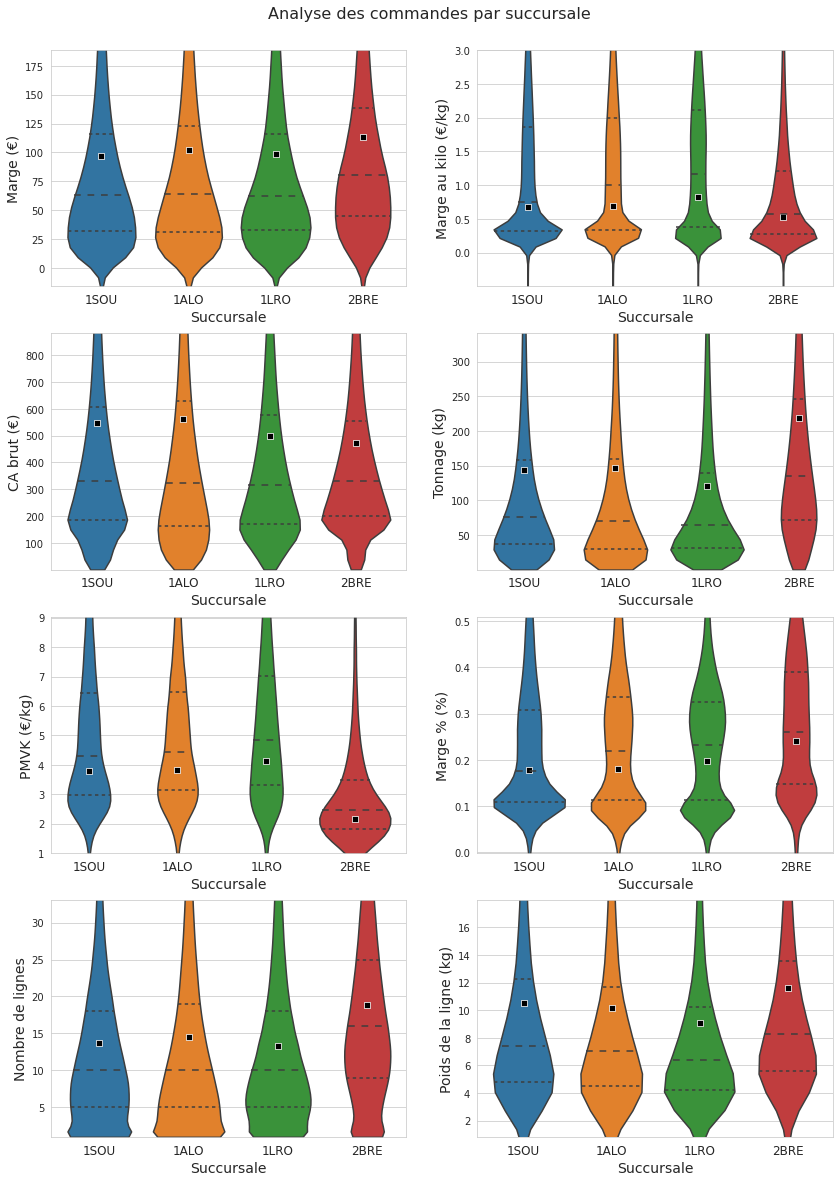

In [129]:
%%time
indicators2 = ['margin', 'brutrevenue',  'PMVK', 'linecount', 'marginperkg', 'weight', 'marginpercent', 'lineweight']
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue=None,
                              hue_order=None,
                              translate=['xaxis', 'indicator',],                              
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par succursale', fontsize=16, y=.91)

In [127]:
utils.pretty_means(data=orders.reset_index(), groupers=['orgacom'], indicators=indicators2)

## Affichage des distributions - par canal de vente

CPU times: user 50.9 s, sys: 22.3 s, total: 1min 13s
Wall time: 41.9 s


Text(0.5, 0.91, 'Analyse des commandes par canal')

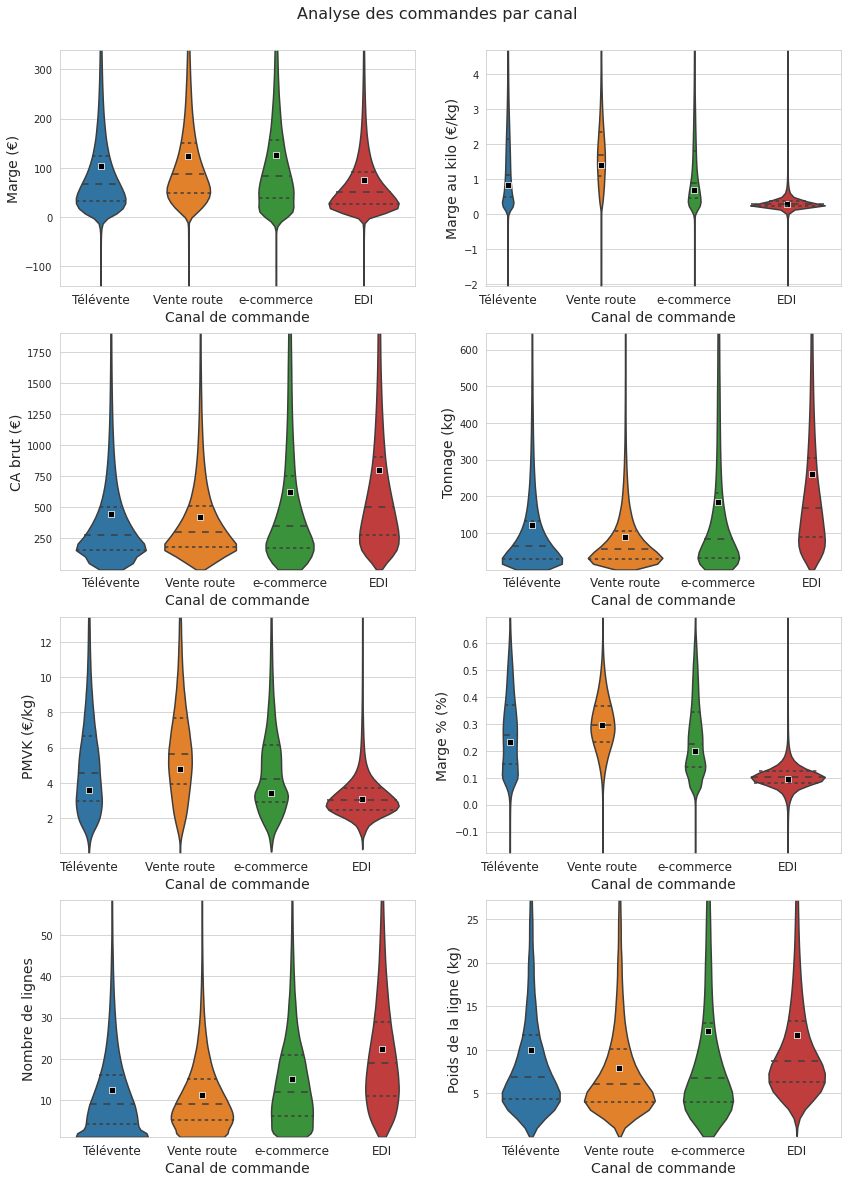

In [130]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

In [137]:
utils.pretty_means(data=orders.reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - hors O'Tacos

CPU times: user 52.2 s, sys: 23.1 s, total: 1min 15s
Wall time: 44 s


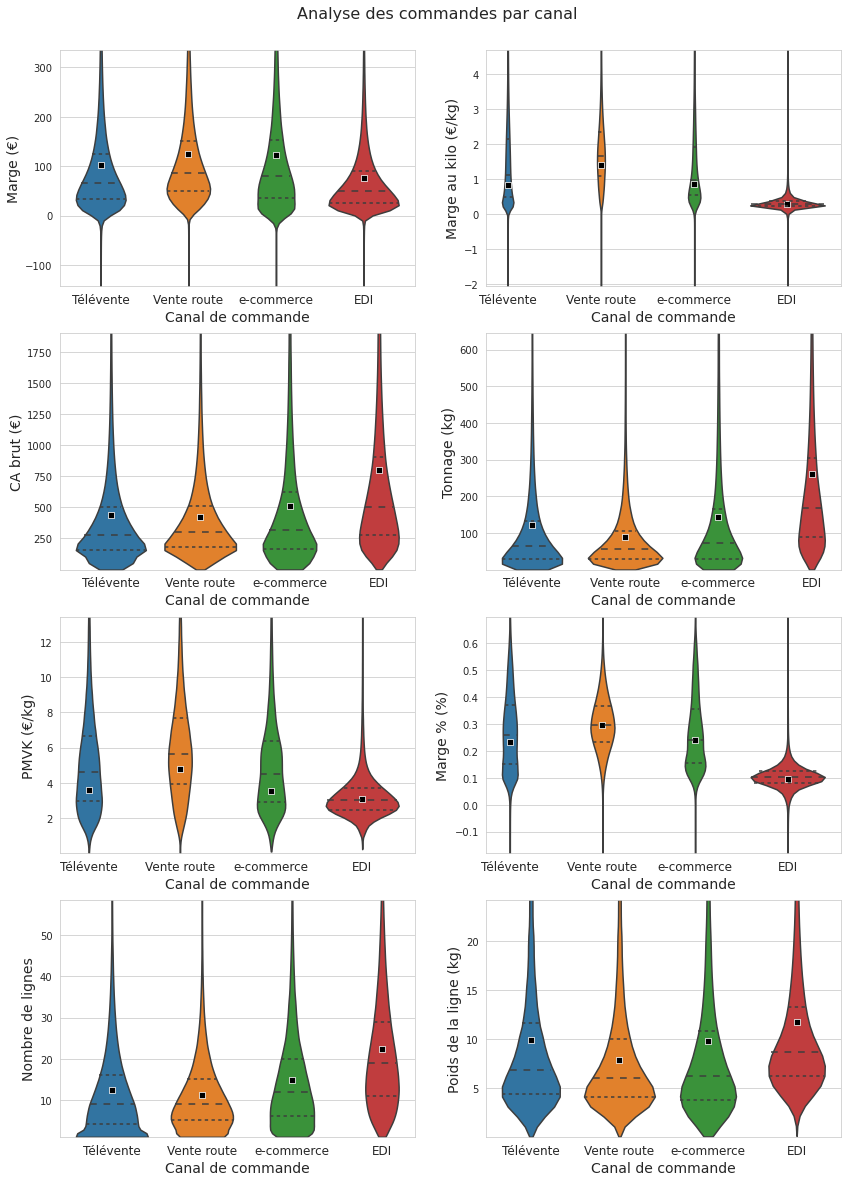

In [139]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filter_otacos,
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - uniquement O'Tacos

CPU times: user 884 ms, sys: 232 ms, total: 1.12 s
Wall time: 1.12 s


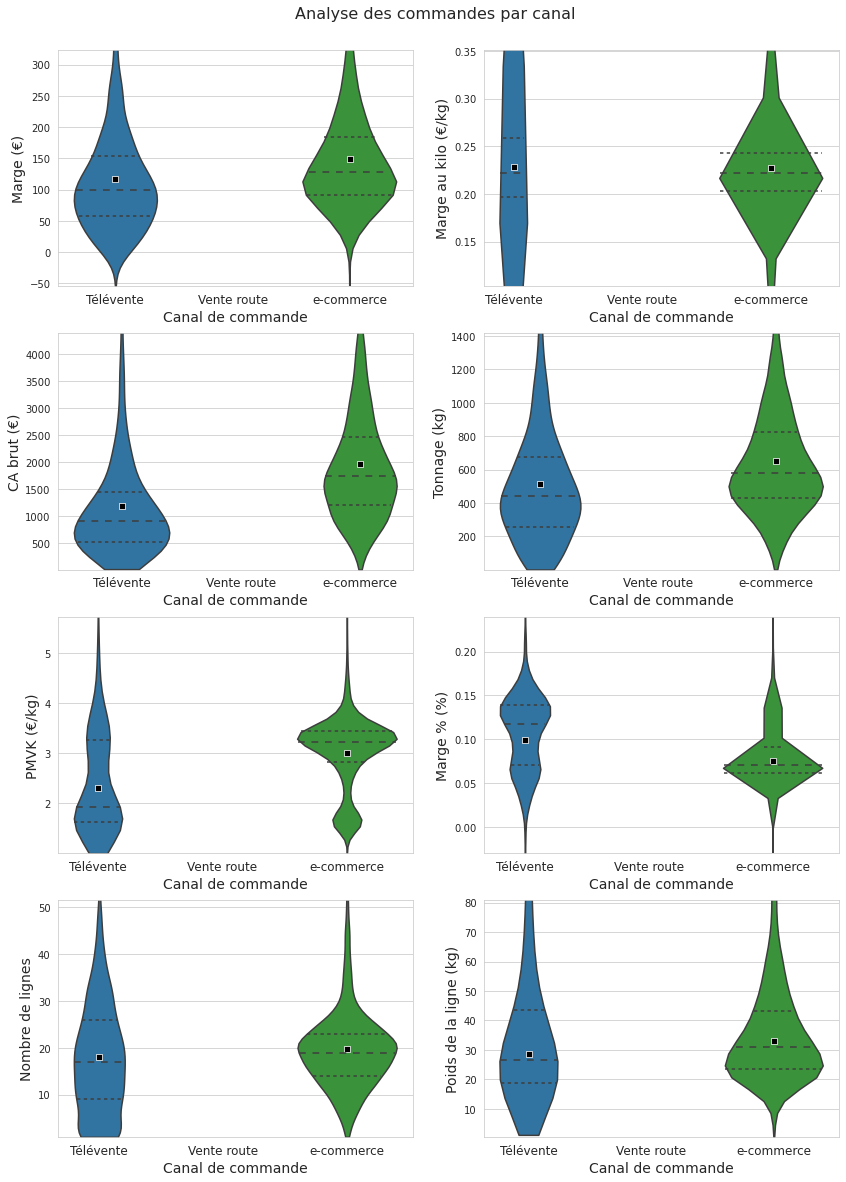

In [143]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(~filter_otacos) & (orders.origin2 != 'VR'),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=1.,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[~filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale

/home/pmasse/WebOrNot/scripts/utils.py:430: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  figsize=(15, 8 * nrows),


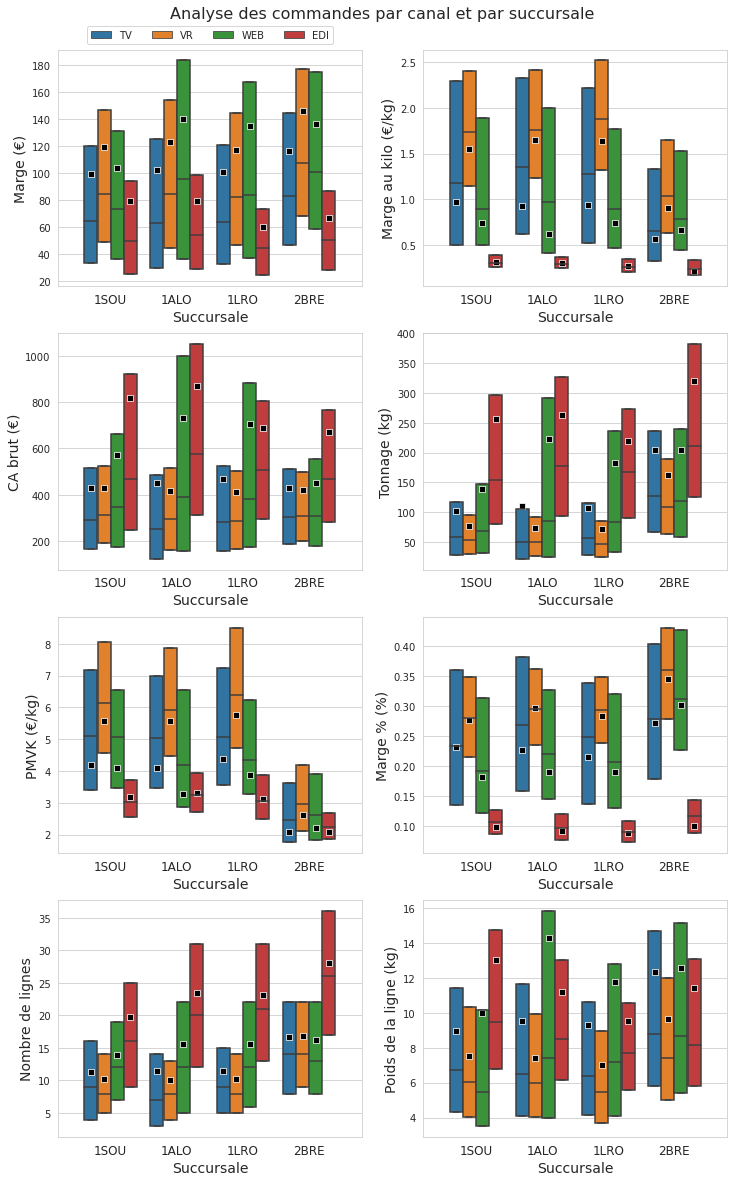

In [145]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle('Analyse des commandes par canal et par succursale', fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

/home/pmasse/WebOrNot/scripts/utils.py:380: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


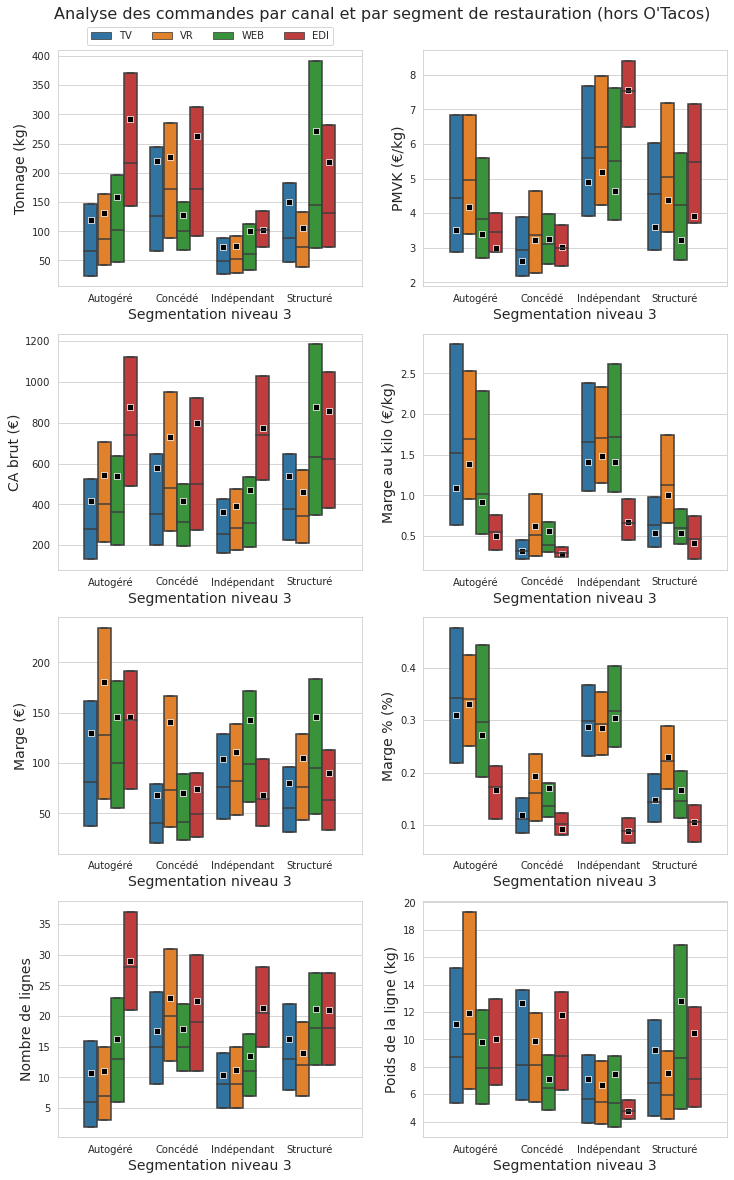

In [43]:
filter_rhd = (orders.seg1 == 'Z3')
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rhd & filter_otacos),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et par segment de restauration (hors O'Tacos)", fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()

In [53]:
def translate(df):
    df['seg3'] = df['seg3'].map(utils.transco['seg3'])
    return(df)

display(utils.compute_means(data=orders.loc[filter_rhd & filter_otacos].reset_index(),
                            groupers=['seg3', 'origin2'],
                            indicators=indicators2)
             .reset_index()
             .pipe(translate)
             .sort_values('seg3')
             .set_index(['seg3', 'origin2'])
             .style.format(formats)
       )

## Impact du Web sur les indicateurs, à la maille du client

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [54]:
orders = compute_zscores(orders,
                         grouper_fields=['orgacom', 'client'],
                         indicators=indicators2)

weight done!
brutrevenue done!
margin done!
linecount done!
PMVK done!
marginperkg done!
marginpercent done!
lineweight done!
ALL DONE!


Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

In [173]:
sample = orders.reset_index().loc[orders.reset_index().origin2 == 'WEB'].sample(1).iloc[0]

In [175]:
oc

'1SOU'

0000067029 - TUTTI PIZZA AUCAMVILLE


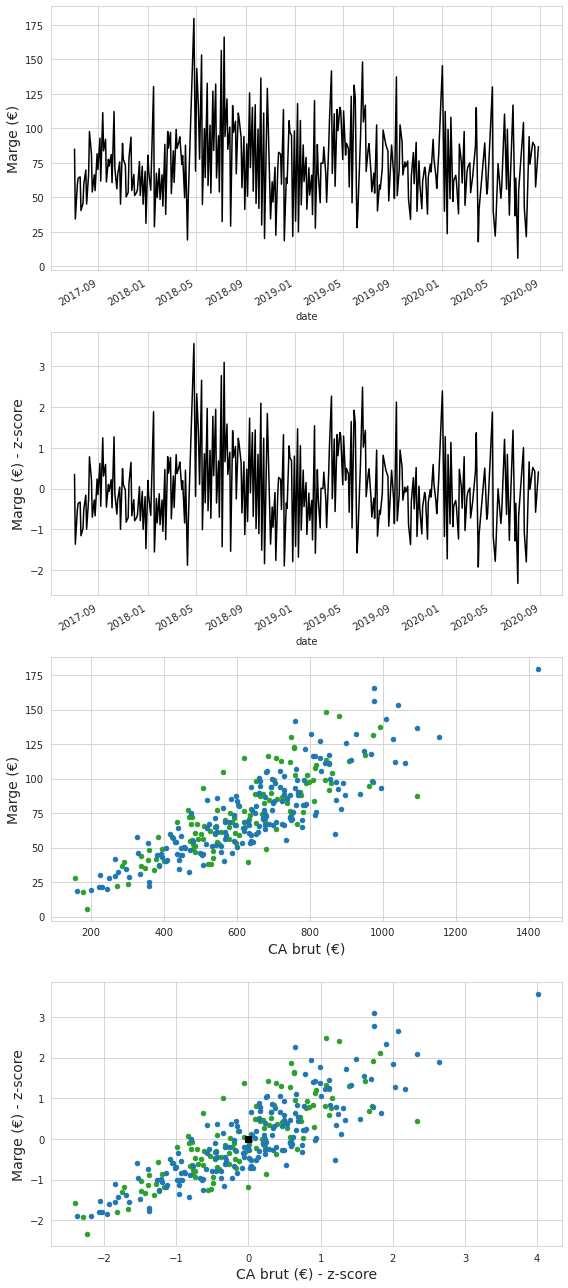

In [176]:
oc, client = '1SOU', '0000067029' #sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.reset_index().client == client)
mask_web = mask_clt & (orders.reset_index().origin2 == 'WEB')
mask_other = mask_clt & (orders.reset_index().origin2 != 'WEB')
col_web = list(mcolor.TABLEAU_COLORS.values())[2]
col_tv = list(mcolor.TABLEAU_COLORS.values())[0]

(orders.reset_index()
       .loc[mask_web]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_web, ax=axs[2])
)
(orders.reset_index()
       .loc[mask_other]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_tv, ax=axs[2])
)

(orders.reset_index()
       .loc[mask_web]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_web, ax=axs[3])
)
(orders.reset_index()
       .loc[mask_other]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_tv, ax=axs[3])
)
axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[0].set_ylabel('Marge (€)', fontsize=14)
axs[1].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_ylabel('Marge (€)', fontsize=14)
axs[3].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_xlabel('CA brut (€)', fontsize=14)
axs[3].set_xlabel('CA brut (€) - z-score', fontsize=14)

fig.tight_layout()

Par contre, cela change les indicateurs si 

<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

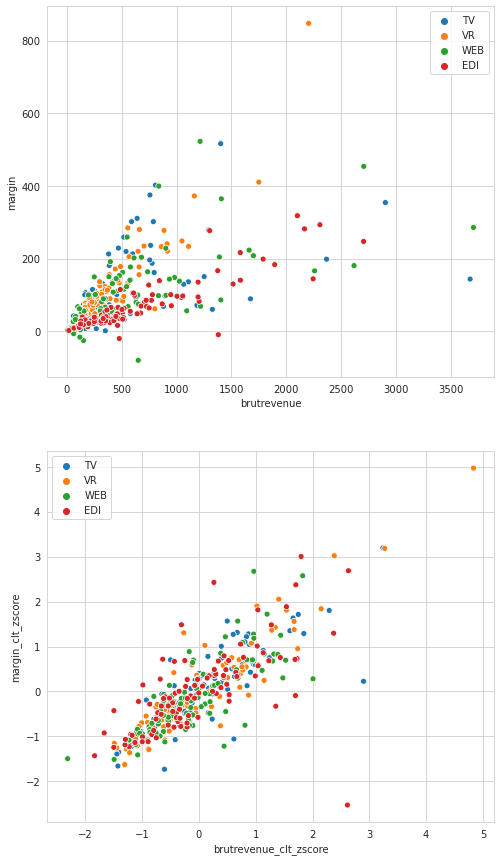

In [58]:
df_sample = pd.concat([orders.loc[orders.origin2 == origin].sample(100) for origin in orders.origin2.unique()], axis=0)

fig, axs = plt.subplots(nrows=2, figsize=(8, 15))
sns.scatterplot(data=df_sample, x='brutrevenue', y='margin', hue=df_sample.origin2.tolist(), ax=axs[0])
sns.scatterplot(data=df_sample, x='brutrevenue_clt_zscore', y='margin_clt_zscore', hue=df_sample.origin2.tolist(), ax=axs[1])

## Affichage des indicateurs en zscore par canal

Text(0.5, 0.91, "Analyse des commandes par canal (hors O'Tacos) - z-score")

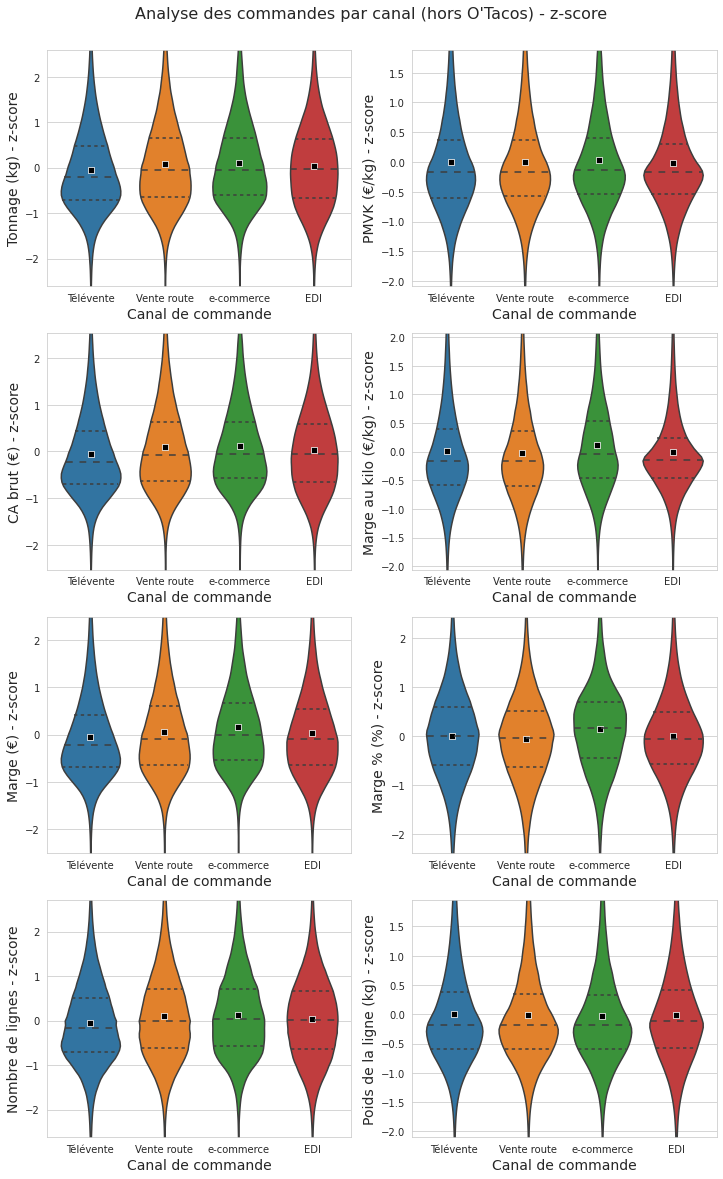

In [59]:
indicators_zscore = [indicator + '_clt_zscore' for indicator in indicators2]


fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos),
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='origin2',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal (hors O'Tacos) - z-score", fontsize=16, y=.91)

In [60]:
display(utils.compute_means(data=orders.loc[filter_otacos].reset_index(),
                            groupers=['origin2'],
                            indicators=indicators_zscore)
#              .reset_index()
#              .pipe(translate)
#              .sort_values('seg3')
#              .set_index(['seg3', 'origin2'])
#              .style.format(formats)
       )

size  weight_clt_zscore  brutrevenue_clt_zscore  \
origin2                                                       
TV       1262116          -0.053851               -0.059287   
VR        485702           0.083703                0.094640   
WEB        90989           0.103214                0.120862   
EDI       596597           0.030038                0.029941   

         margin_clt_zscore  linecount_clt_zscore  PMVK_clt_zscore  \
origin2                                                             
TV               -0.048373             -0.064116         0.005971   
VR                0.065238              0.097007         0.002266   
WEB               0.157682              0.130384         0.039571   
EDI               0.025174              0.036779        -0.020524   

         marginperkg_clt_zscore  marginpercent_clt_zscore  \
origin2                                                     
TV                     0.008000                  0.010357   
VR                    -0.032070                 -0.058086   
WEB                    0.117048                  0.152792   
EDI                   -0.008666                  0.002076   

         lineweight_clt_zscore  
origin2                         
TV                    0.008805  
VR                   -0.003733  
WEB                  -0.032711  
EDI                  -0.010598

## Affichage des indicateurs en zscore par canal et succursale

/home/pmasse/WebOrNot/scripts/utils.py:380: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


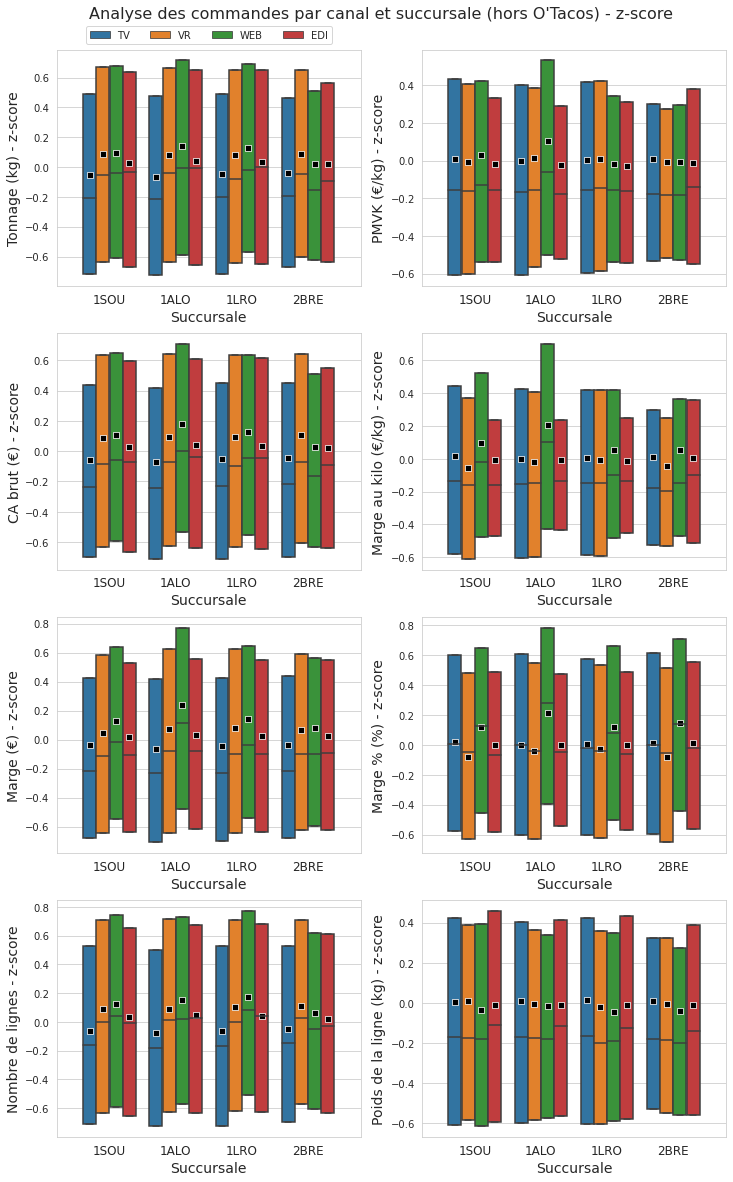

In [98]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos),
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', ],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et succursale (hors O'Tacos) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [62]:
display(utils.compute_means(data=orders.loc[filter_otacos].reset_index(),
                            groupers=['orgacom', 'origin2'],
                            indicators=indicators_zscore)
#              .reset_index()
#              .pipe(translate)
#              .sort_values('seg3')
#              .set_index(['seg3', 'origin2'])
#              .style.format(formats)
       )

size  weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom origin2                                                      
1SOU    TV       419174          -0.054326               -0.056801   
        VR       155575           0.085017                0.090018   
        WEB       32609           0.095761                0.107612   
        EDI      253486           0.025339                0.024836   
1ALO    TV       376500          -0.064969               -0.073838   
        VR       158305           0.080077                0.093925   
        WEB       28858           0.142293                0.181972   
        EDI      198767           0.038627                0.038638   
1LRO    TV       257076          -0.049172               -0.053429   
        VR        98596           0.082961                0.095905   
        WEB       14319           0.129643                0.124373   
        EDI       74026           0.035191                0.033754   
2BRE    TV       209366          -0.038654               -0.045288   
        VR        73226           0.089749                0.104302   
        WEB       15203           0.020132                0.029978   
        EDI       70318           0.017276                0.019746   

                 margin_clt_zscore  linecount_clt_zscore  PMVK_clt_zscore  \
orgacom origin2                                                             
1SOU    TV               -0.040001             -0.062195         0.010950   
        VR                0.048114              0.090236        -0.006746   
        WEB               0.128854              0.126524         0.028379   
        EDI               0.020041              0.031190        -0.017636   
1ALO    TV               -0.064998             -0.074945        -0.000137   
        VR                0.071967              0.092492         0.011622   
        WEB               0.238557              0.149423         0.105777   
        EDI               0.031165              0.046601        -0.024354   
1LRO    TV               -0.047157             -0.062663         0.006067   
        VR                0.082273              0.105875         0.009448   
        WEB               0.142129              0.176259        -0.019459   
        EDI               0.026693              0.042506        -0.029851   
2BRE    TV               -0.036732             -0.050276         0.006868   
        VR                0.064133              0.109216        -0.008483   
        WEB               0.080651              0.059316        -0.006499   
        EDI               0.025145              0.023137        -0.010293   

                 marginperkg_clt_zscore  marginpercent_clt_zscore  \
orgacom origin2                                                     
1SOU    TV                     0.019993                  0.020666   
        VR                    -0.057718                 -0.079086   
        WEB                    0.095369                  0.116609   
        EDI                   -0.009906                 -0.000637   
1ALO    TV                    -0.004238                  0.000837   
        VR                    -0.016821                 -0.043279   
        WEB                    0.206521                  0.214275   
        EDI                   -0.008559                  0.001775   
1LRO    TV                     0.005195                  0.005245   
        VR                    -0.009300                 -0.030075   
        WEB                    0.054796                  0.118162   
        EDI                   -0.016252                 -0.001012   
2BRE    TV                     0.009440                  0.013112   
        VR                    -0.041205                 -0.083193   
        WEB                    0.052343                  0.146312   
        EDI                    0.003486                  0.015961   

                 lineweight_clt_zscore  
orgacom origin2                         
1SOU    TV                    0.006789  
     

## Affichage des indicateurs en zscore par canal et par segment

/home/pmasse/WebOrNot/scripts/utils.py:380: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


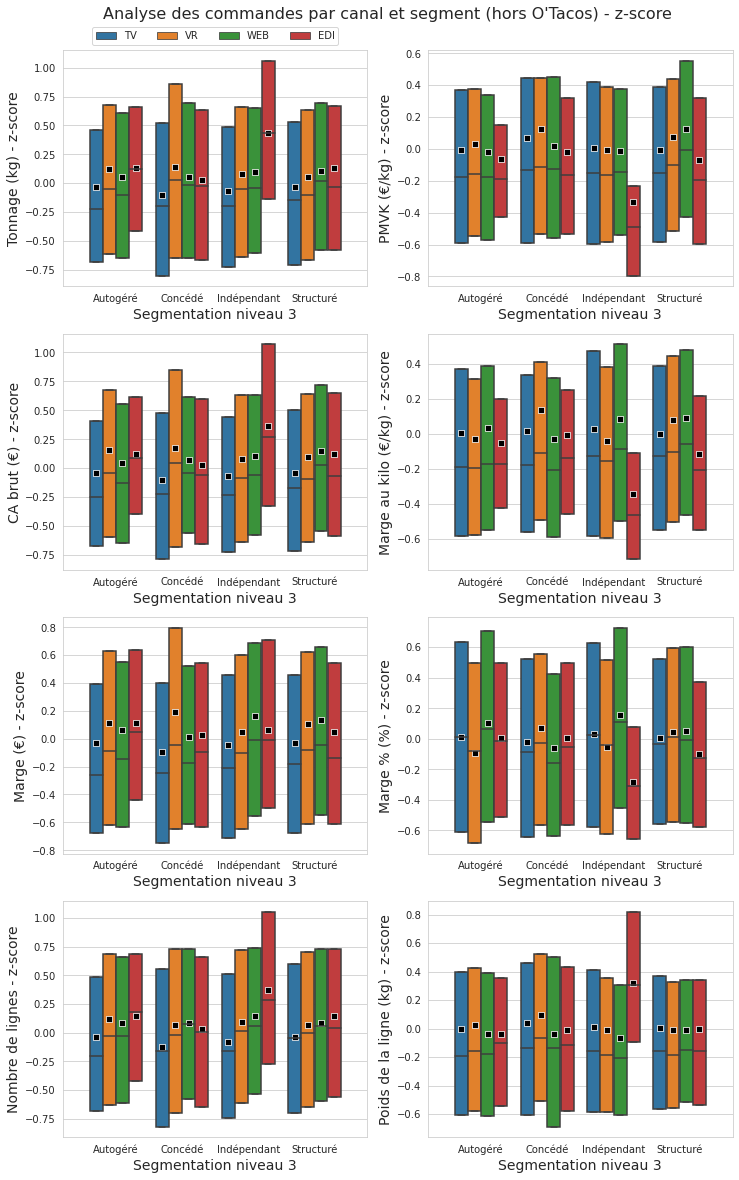

In [63]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

In [64]:
display(utils.compute_means(data=orders.loc[filter_otacos & filter_rhd].reset_index(),
                            groupers=['seg3', 'origin2'],
                            indicators=indicators_zscore)
             .reset_index()
             .pipe(translate)
             .sort_values('seg3')
             .set_index(['seg3', 'origin2'])
#              .style.format(formats)
       )

size  weight_clt_zscore  brutrevenue_clt_zscore  \
seg3        origin2                                                      
Autogéré    TV       414707          -0.032308               -0.039471   
            VR        96462           0.119453                0.154593   
            WEB       31749           0.054349                0.041534   
            EDI        1141           0.131623                0.120942   
Concédé     TV       153189          -0.098355               -0.099813   
            VR         1292           0.143493                0.178287   
            WEB        1496           0.049879                0.074219   
            EDI      573131           0.025835                0.026083   
Indépendant TV       454259          -0.063763               -0.066849   
            VR       352200           0.075646                0.078752   
            WEB       24270           0.092713                0.105834   
            EDI         168           0.430871                0.367486   
Structuré   TV       159035          -0.033793               -0.040620   
            VR        11609           0.052687                0.095948   
            WEB       17275           0.107555                0.151604   
            EDI       22143           0.131172                0.123164   

                     margin_clt_zscore  linecount_clt_zscore  PMVK_clt_zscore  \
seg3        origin2                                                             
Autogéré    TV               -0.031124             -0.034601        -0.005329   
            VR                0.112217              0.120020         0.029418   
            WEB               0.061664              0.082029        -0.017828   
            EDI               0.109374              0.146731        -0.065289   
Concédé     TV               -0.092008             -0.122339         0.068158   
            VR                0.189041              0.066212         0.122235   
            WEB               0.014899              0.086621         0.019895   
            EDI               0.024127              0.032324        -0.018536   
Indépendant TV               -0.048120             -0.080039         0.007089   
            VR                0.051013              0.092693        -0.008266   
            WEB               0.159921              0.150349        -0.010561   
            EDI               0.064775              0.375259        -0.330449   
Structuré   TV               -0.029466             -0.035026        -0.009700   
            VR                0.107613              0.071980         0.074817   
            WEB               0.137123              0.088790         0.125304   
            EDI               0.048233              0.144558        -0.067136   

                     marginperkg_clt_zscore  marginpercent_clt_zscore  \
seg3        origin2                                                     
Autogéré    TV                     0.004172                  0.013510   
            VR                    -0.029014                 -0.091429   
            WEB                    0.035543                  0.101020   
            EDI                   -0.052444                  0.008255   
Concédé     TV                     0.015312                 -0.022427   
            VR                     0.138013                  0.071843   
            WEB                   -0.031549                 -0.057723   
            EDI                   -0.004321                  0.005983   
Indépendant TV                     0.025521                  0.034006   
            VR                    -0.038752                 -0.054317   
            WEB                    0.087068                  0.153694   
            EDI                   -0.344524                 -0.280068   
Structuré   TV                     0.000669                  0.004695   
            VR                     0.080308                  0.041407   
            WEB                    0.088765                  0.

## Affichage des indicateurs en zscore par canal et par segment - hors EDI et SDR

**ATTENTION !!!** Cet indicateur devrait être recalculé, car la filtration du canal EDI filtre une partie des commandes d'un client et donc le zscore n'est plus bon.

/home/pmasse/WebOrNot/scripts/utils.py:380: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


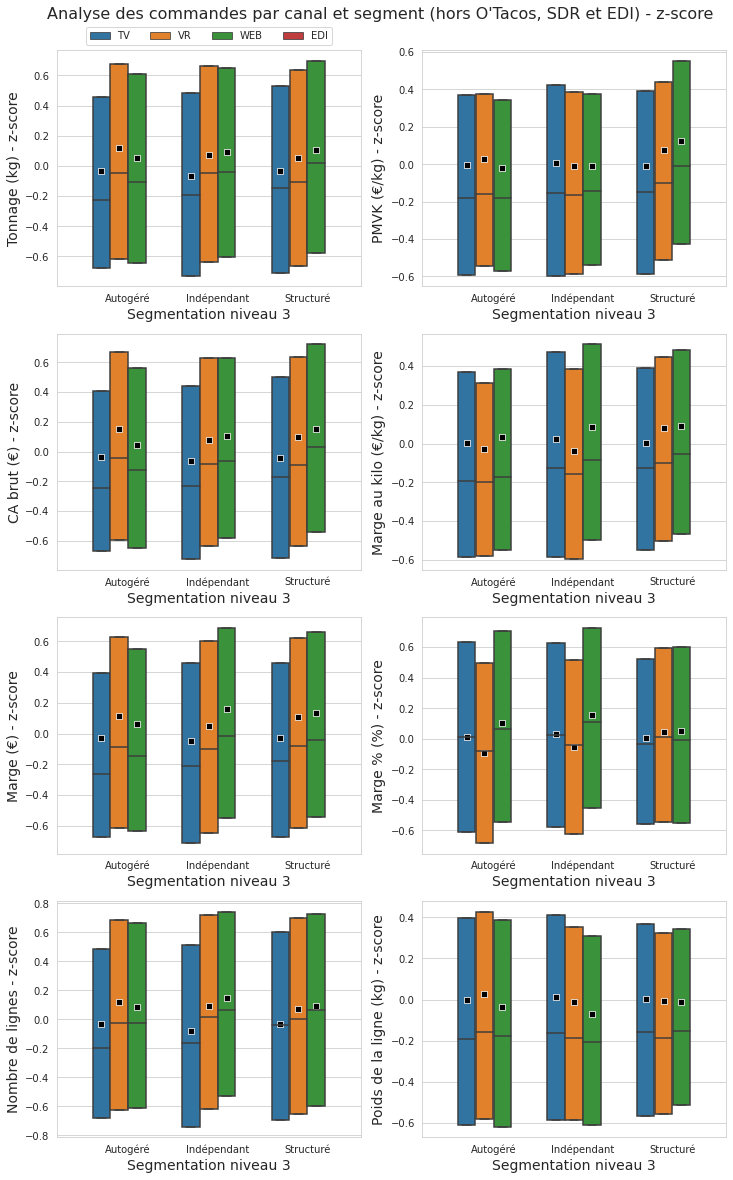

In [65]:
filter_not_edi = ~orders.origin2.isin(['EDI'])
filter_not_sdr = ~orders.seg3.isin(['ZJ'])

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos & filter_not_edi & filter_not_sdr & filter_rhd),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos, SDR et EDI) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

In [66]:
display(utils.compute_means(data=orders.loc[filter_otacos & filter_rhd & filter_not_edi & filter_not_sdr].reset_index(),
                            groupers=['seg3', 'origin2'],
                            indicators=indicators_zscore)
             .reset_index()
             .pipe(translate)
             .sort_values('seg3')
             .set_index(['seg3', 'origin2'])
#              .style.format(formats)
       )

size  weight_clt_zscore  brutrevenue_clt_zscore  \
seg3        origin2                                                      
Autogéré    TV       414707          -0.032308               -0.039471   
            VR        96462           0.119453                0.154593   
            WEB       31749           0.054349                0.041534   
Indépendant TV       454259          -0.063763               -0.066849   
            VR       352200           0.075646                0.078752   
            WEB       24270           0.092713                0.105834   
Structuré   TV       159035          -0.033793               -0.040620   
            VR        11609           0.052687                0.095948   
            WEB       17275           0.107555                0.151604   

                     margin_clt_zscore  linecount_clt_zscore  PMVK_clt_zscore  \
seg3        origin2                                                             
Autogéré    TV               -0.031124             -0.034601        -0.005329   
            VR                0.112217              0.120020         0.029418   
            WEB               0.061664              0.082029        -0.017828   
Indépendant TV               -0.048120             -0.080039         0.007089   
            VR                0.051013              0.092693        -0.008266   
            WEB               0.159921              0.150349        -0.010561   
Structuré   TV               -0.029466             -0.035026        -0.009700   
            VR                0.107613              0.071980         0.074817   
            WEB               0.137123              0.088790         0.125304   

                     marginperkg_clt_zscore  marginpercent_clt_zscore  \
seg3        origin2                                                     
Autogéré    TV                     0.004172                  0.013510   
            VR                    -0.029014                 -0.091429   
            WEB                    0.035543                  0.101020   
Indépendant TV                     0.025521                  0.034006   
            VR                    -0.038752                 -0.054317   
            WEB                    0.087068                  0.153694   
Structuré   TV                     0.000669                  0.004695   
            VR                     0.080308                  0.041407   
            WEB                    0.088765                  0.053421   

                     lineweight_clt_zscore  
seg3        origin2                         
Autogéré    TV                   -0.003603  
            VR                    0.028183  
            WEB                  -0.037092  
Indépendant TV                    0.013403  
            VR                   -0.012693  
            WEB                  -0.068870  
Structuré   TV                    0.002277  
            VR                   -0.007736  
            WEB                  -0.011700

## Première modélisation : bascule à la première commande Web

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [67]:
try:
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )
except KeyError: 
    orders = orders.reset_index()
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )    

On initialise la table des mises à jour de statuts :

In [68]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [69]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [70]:
status_updates

new_stat
orgacom client     date               
1SOU    0000010078 2017-07-17       TV
                   2017-11-06      WEB
        0000019613 2017-07-04       TV
        0000043428 2017-07-04       TV
        0000043827 2019-07-12       VR
...                                ...
2BRE    SL008B     2017-12-01       TV
        SL008C     2017-07-11       TV
        SL008R     2017-07-28       TV
        SL009N     2017-07-04       TV
        SLD008B    2018-09-14       TV

[37000 rows x 1 columns]

On rappatrie le statut calculé depuis la tables des mises à jour de statut (`status_updates`) dans la table des commandes (`orders`).

In [71]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)

try:
    del(orders['clt_stat'])
except KeyError:
    pass       

orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
) 
    
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [72]:
orders.sample(5)

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000066051 2020-02-13   39.97        62.80   15.000          2   
1ALO    0000120534 2019-11-12   42.20       781.14  138.416         27   
1SOU    0000184066 2020-07-16   26.24       453.83  142.684          4   
        0000121588 2018-06-18  117.77       434.63   78.753         34   
2BRE    0000077310 2018-10-11   93.53       697.19  242.856         30   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000066051 2020-02-13      TV   Z3   Z4   ZI   ZB  ZM  ...   7.500000   
1ALO    0000120534 2019-11-12     EDI   Z3   Z4   ZJ   ZF  ZM  ...   5.126519   
1SOU    0000184066 2020-07-16     EDI   Z3   Z4   ZJ   ZE  ZN  ...  35.671000   
        0000121588 2018-06-18      TV   Z3   Z4   ZI   ZD  ZO  ...   2.316265   
2BRE    0000077310 2018-10-11     EDI   Z3   Z4   ZJ   ZF  ZM  ...   8.095200   

                              weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000066051 2020-02-13          0.354563               -0.105695   
1ALO    0000120534 2019-11-12         -1.067129               -1.127246   
1SOU    0000184066 2020-07-16         -0.813654               -0.853365   
        0000121588 2018-06-18          0.241537                0.512282   
2BRE    0000077310 2018-10-11          0.567745                1.339780   

                               margin_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                  
1SOU    0000066051 2020-02-13           0.183708              0.409567   
1ALO    0000120534 2019-11-12          -1.061894             -0.839780   
1SOU    0000184066 2020-07-16          -0.705359             -0.735402   
        0000121588 2018-06-18           0.646298              0.648002   
2BRE    0000077310 2018-10-11           1.758095              0.005250   

                               PMVK_clt_zscore  marginperkg_clt_zscore  \
orgacom client     date                                                  
1SOU    0000066051 2020-02-13        -0.607162               -0.283470   
1ALO    0000120534 2019-11-12         0.817178                0.002100   
1SOU    0000184066 2020-07-16        -0.245286               -0.305951   
        0000121588 2018-06-18         0.316094                0.562608   
2BRE    0000077310 2018-10-11         1.266141                1.693803   

                               marginpercent_clt_zscore  \
orgacom client     date                                   
1SOU    0000066051 2020-02-13                  0.670813   
1ALO    0000120534 2019-11-12                 -0.680114   
1SOU    0000184066 2020-07-16                 -0.358801   
        0000121588 2018-06-18                  0.558703   
2BRE    0000077310 2018-10-11                  1.258443   

                               lineweight_clt_zscore  clt_stat  
orgacom client     date                                         
1SOU    0000066051 2020-02-13               0.019439        TV  
1ALO    0000120534 2019-11-12              -1.099368       EDI  
1SOU    0000184066 2020-07-16              -0.638910        TV  
        0000121588 2018-06-18              -0.483185        VR  
2BRE    0000077310 2018-10-11               0.905222       EDI  

[5 rows x 25 columns]

On rappatrie ensuite de quoi calculer les indicateurs dans la table des mises à jour de statut.

In [73]:
(
orders.groupby(['orgacom', 'client', 'clt_stat'], observed=True)
      .agg({'margin': 'sum',
            'brutrevenue': 'sum', 
            'weight': 'sum', 
            'linecount': 'sum', 
            'origin2': 'size',
           })
      .rename({'origin2': 'ordercount'}, axis=1)
)

margin  brutrevenue      weight  linecount  \
orgacom client     clt_stat                                                 
1SOU    0000010078 TV           11.01        20.82       2.350          2   
                   WEB         221.62       452.95      25.460         18   
        0000019613 TV        47824.80    470059.03  129763.078       5624   
        0000043428 TV        20550.61    107904.93   24274.185       3153   
        0000043827 VR          922.65      4220.09     862.249        116   
...                               ...          ...         ...        ...   
2BRE    SL008B     TV          190.97      4398.58    3303.984          2   
        SL008C     TV         7578.42     71848.30   21946.816        367   
        SL008R     TV          263.63      6992.88    2009.948         43   
        SL009N     TV         5107.84     14556.72    4057.578        172   
        SLD008B    TV            3.82        70.05       4.400          1   

                             ordercount  
orgacom client     clt_stat              
1SOU    0000010078 TV                 1  
                   WEB                6  
        0000019613 TV               485  
        0000043428 TV               163  
        0000043827 VR                 9  
...                                 ...  
2BRE    SL008B     TV                 2  
        SL008C     TV                95  
        SL008R     TV                25  
        SL009N     TV                48  
        SLD008B    TV                 1  

[37000 rows x 5 columns]

In [74]:
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'new_stat']).join(
    orders.rename({'clt_stat': 'new_stat'}, axis=1)
          .groupby(['orgacom', 'client', 'new_stat'], observed=True)
          .agg({'margin': 'sum',
                'brutrevenue': 'sum', 
                'weight': 'sum', 
                'linecount': 'sum', 
                'origin2': 'size',
               })
          .rename({'origin2': 'ordercount'}, axis=1)         
)
status_updates

date    margin  brutrevenue      weight  \
orgacom client     new_stat                                                 
1SOU    0000010078 TV       2017-07-17     11.01        20.82       2.350   
                   WEB      2017-11-06    221.62       452.95      25.460   
        0000019613 TV       2017-07-04  47824.80    470059.03  129763.078   
        0000043428 TV       2017-07-04  20550.61    107904.93   24274.185   
        0000043827 VR       2019-07-12    922.65      4220.09     862.249   
...                                ...       ...          ...         ...   
2BRE    SL008B     TV       2017-12-01    190.97      4398.58    3303.984   
        SL008C     TV       2017-07-11   7578.42     71848.30   21946.816   
        SL008R     TV       2017-07-28    263.63      6992.88    2009.948   
        SL009N     TV       2017-07-04   5107.84     14556.72    4057.578   
        SLD008B    TV       2018-09-14      3.82        70.05       4.400   

                             linecount  ordercount  
orgacom client     new_stat                         
1SOU    0000010078 TV                2           1  
                   WEB              18           6  
        0000019613 TV             5624         485  
        0000043428 TV             3153         163  
        0000043827 VR              116           9  
...                                ...         ...  
2BRE    SL008B     TV                2           2  
        SL008C     TV              367          95  
        SL008R     TV               43          25  
        SL009N     TV              172          48  
        SLD008B    TV                1           1  

[37000 rows x 6 columns]

In [75]:
status_updates['PMVK'] = status_updates.brutrevenue / status_updates.weight
status_updates['marginperkg'] = status_updates.margin / status_updates.weight
status_updates['marginpercent'] = status_updates.margin / status_updates.brutrevenue
status_updates['lineweight'] = status_updates.weight / status_updates.linecount
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    status_updates[indicator] /= status_updates['ordercount']
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'date'])
status_updates

new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       TV   11.010000    20.820000     2.350000   
                   2017-11-06      WEB   36.936667    75.491667     4.243333   
        0000019613 2017-07-04       TV   98.607835   969.193876   267.552738   
        0000043428 2017-07-04       TV  126.077362   661.993436   148.921380   
        0000043827 2019-07-12       VR  102.516667   468.898889    95.805444   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17   2.000000           1   8.859574     4.685106   
                   2017-11-06   3.000000           6  17.790652     8.704635   
        0000019613 2017-07-04  11.595876         485   3.622441     0.368555   
        0000043428 2017-07-04  19.343558         163   4.445254     0.846604   
        0000043827 2019-07-12  12.888889           9   4.894282     1.070051   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  
orgacom client     date                                    
1SOU    0000010078 2017-07-17       0.528818     1.175000  
                   2017-11-06       0.489281     1.414444  
        0000019613 2017-07-04       0.101742    23.073094  
        0000043428 2017-07-04       0.190451     7.698758  
        0000043827 2019-07-12       0.218633     7.433181  
...                                      ...          ...  
2BRE    SL008B     2017-12-01       0.043416  1651.992000  
        SL008C     2017-07-11       0.105478    59.800589  
        SL008R     2017-07-28       0.037700    46.742977  
        SL009N     2017-07-04       0.350892    23.590570  
        SLD008B    2018-09-14       0.054532     4.400000  

[37000 rows x 10 columns]

In [76]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    0000282373 2020-08-31  177.42      1401.58  488.036         88   
        0000283953 2020-08-31   43.79       421.67  564.980         28   
        0000284089 2020-08-31   89.39       186.75   90.200         12   
        0000284540 2020-08-31  262.04      1252.07  639.326         97   
        0000284735 2020-08-31  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...   0.611222   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...   0.804800   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...   1.500000   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...   6.770667   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...   8.067600   
...                               ...  ...  ...  ...  ...  ..  ...        ...   
2BRE    0000282373 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZP  ...   5.545864   
        0000283953 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZN  ...  20.177857   
        0000284089 2020-08-31      TV   Z3   Z5   ZK   ZG  ZU  ...   7.516667   
        0000284540 2020-08-31      TV   Z3   Z4   ZJ   ZF  ZP  ...   6.590990   
        0000284735 2020-08-31      VR   Z3   Z5   ZK   ZG  ZU  ...   4.055793   

                              weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000065940 2017-07-03         -0.530799               -0.420589   
                   2017-08-28         -0.480297               -0.376466   
                   2017-09-08         -0.580390               -0.508474   
                   2017-09-15         -0.237125               -0.113095   
                   2017-09-25          0.159954               -0.078432   
...                                         ...                     ...   
2BRE    0000282373 2020-08-31          0.000000                0.000000   
        0000283953 2020-08-31          0.000000                0.000000   
        0000284089 2020-08-31          0.000000                0.000000   
        0000284540 2020-08-31          0.000000                0.000000   
        0000284735 2020-08-31          0.000000                0.000000   

                               margin_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03          -0.515855              2.795673   
                   2017-08-28          -0.423595              3.252761   
                   2017-09-08          -0.610631             -0.403938   
                   2017-09-15          -0.033868              0.053150   
                   2017-09-25          -0.062385              0.967324   
...                                          ...                   ...   
2BRE    0000282373 2020-08-31           0.000000              0.000000   
        0000283953 2020-08-31           0.000000              0.000000   
        0000284089 2020-08-31           0.000000              0.000000   
        0000284540 2020-08-31           0.000000              0.000000   
        0000284735 2020-08-31           0.000000              0.000000   

                               PMVK_clt_zscore  marginperkg_clt_zscore  \
o

In [ ]:
compute_zscores(status_updates, ['orgacom', 'client'], indicators2)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=status_updates.reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [ ]:
compute_distribution(data=status_updates,
                     indicators=['margin', 'weight'],
                     x='orgacom',
                     hue='new_stat',
                     percentile_selection=.99,
                     IQR_factor_selection=3.,
                     IQR_factor_plot=.5,
                    )

In [ ]:
show_mean = {
    'weight': True,
    'brutrevenue': True,
    'margin': True,
    'linecount': True,
    'PMVK': False,
    'marginperkg': False,
    'marginpercent': False,
    'lineweight': False,    
    'weight_clt_zscore': True,
    'brutrevenue_clt_zscore': True,
    'margin_clt_zscore': True,
    'linecount_clt_zscore': True,
    'PMVK_clt_zscore': False,
    'marginperkg_clt_zscore': False,
    'marginpercent_clt_zscore': False,
    'lineweight_clt_zscore': False,        
}

In [ ]:
libs = {
    'weight': 'Poids (kg)',
    'brutrevenue': 'CA brut (€)',
    'margin': 'Marge en valeur (€)',
    'linecount': 'Nombre de lignes à la commande',
    'PMVK': 'PMVK (€/kg)',
    'marginperkg': 'Marge au kilo (€/kg)',
    'marginpercent': 'Marge pourcent (%)',
    'lineweight': 'Poids moyen de la ligne (kg)',    
    'weight_clt_zscore': 'Poids - zscore',
    'brutrevenue_clt_zscore': 'CA brut - zscore',
    'margin_clt_zscore': 'Marge en valeur - zscore',
    'linecount_clt_zscore': 'Nombre de lignes à la commande - zscore',
    'PMVK_clt_zscore': 'PMVK - zscore',
    'marginperkg_clt_zscore': 'Marge au kilo - zscore',
    'marginpercent_clt_zscore': 'Marge pourcent - zscore',
    'lineweight_clt_zscore': 'Poids moyen de la ligne - zscore',   
}

In [ ]:
orders.columns

In [ ]:
with pd.option_context('display.max_columns', None):
    display(orders.reset_index().loc[lambda x: x.orgacom == '2BRE'].sort_values('PMVK', ascending=False))

In [ ]:
status_updates.reset_index().loc[lambda x: x.orgacom == '2BRE'].sort_values('PMVK', ascending=False)

In [ ]:
indicators = ['margin', 'weight', 'brutrevenue', 'linecount', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight']
# indicators = ['weight', 'brutrevenue']
x = 'new_stat'
hue = None #'new_stat'
fig, axs = plt.subplots(nrows=len(indicators), figsize=(15 , 8* len(indicators)), )
stats = compute_distribution(data=status_updates,
                             indicators=indicators,
                             x=x,
                             hue=hue,
                             percentile_selection=.99,
                             IQR_factor_selection=2.,
                             IQR_factor_plot=.5,
                            )
plot_ranges = stats.T.groupby(level=0, axis=0).agg({'min_plot_selection': 'min',
                                                    'max_plot_selection': 'max',
                                                    'minimum_plot_range': 'min',
                                                    'maximum_plot_range': 'max',
                                                   })
reset = status_updates.reset_index()
for i, indicator in enumerate(indicators):
    sns.violinplot(data=(reset.loc[(reset[indicator] >= plot_ranges.loc[indicator, 'min_plot_selection']) &
                                   (reset[indicator] <= plot_ranges.loc[indicator, 'max_plot_selection'])
                                  ]),
                   y=indicator,
                   x=x,
                   cut=0.,
                   hue=hue,
#                    scale='count',
                   inner='quartile',
                   ax=axs[i])
    axs[i].set_ylim(plot_ranges.loc[indicator, 'minimum_plot_range'],
                    plot_ranges.loc[indicator, 'maximum_plot_range'])
    if show_mean[indicator] and not hue:
        axs[i].scatter(x=[0, 1, 2, 3], y=[reset[['orgacom', indicator]].groupby('orgacom').mean()], marker='s', color='k')
    axs[i].set_ylabel(libs[indicator], fontsize=14)
    axs[i].set_xlabel('Succursale', fontsize=14)
    axs[i].set_title('Répartition des commandes - clts avec au moins une commande Web', fontsize=16)
#     ax.set_xticks([])
#     axs[i].grid(linestyle='--')

In [ ]:
orders.groupby('origin2')['margin_clt_zscore'].describe().style.format('{:.3f}')

In [ ]:
orders = compute_zscores(orders, grouper_fields=['orgacom', 'client'], indicators=indicators)

In [ ]:
orders.info()

In [ ]:
reload(utils)

In [ ]:
fig, axs = utils.plot_distrib(data=orders,
                              filter=filter_otacos, 
                              indicators=['PMVK', 'PMVK_clt_zscore'],
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              hue='orgacom', #'origin2', 
                              hue_order=['2BRE', '1ALO', '1LRO', '1SOU',],
                              kind='violin',
                              percentile_selection=.98,
                              IQR_factor_selection=1.5,
                              IQR_factor_plot=1.,
                              show_means=True,
                             )

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.violinplot(data=status_updates.loc[:].reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                cut=0.,
#                 scale='count', 
                
                inner='quartile',   
                showfliers=False,
                
                whis=0.,
                **boxplot_args,
               )

#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
axs[0, 0].set_ylim(-5, 200)
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=status_updates.reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 order=['ZK', 'ZL', 'ZI'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.reset_index(),
                y=indicator + '_clt_zscore',
                x='clt_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
#     axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB - zscore', fontsize=16, y=1.025)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.reset_index(),
                y=indicator + '_clt_zscore',
                x='orgacom',
#                 order=['TV', 'VR', 'WEB'],
                hue='clt_stat',
                hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB - zscore', fontsize=16, y=1.025)

## Plot des détails

In [ ]:
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
sample_clt = (
# '0000210861'
# '0000020511'
'0000020697'
)
to_plot = orders.loc[idx[:, sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
to_plot

In [ ]:
status_plot = status_updates.loc[idx[: , sample_clt, :]]
status_plot

In [ ]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Détail pour ' + sample_clt + " - " + ind_, plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [ ]:
orders

In [ ]:
status_updates

In [ ]:
status_updates['end_date'] = status_updates.reset_index().groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates.reset_index(inplace=True)

In [ ]:
status_updates

In [ ]:
status_updates.groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates['end_date'] = (
    status_updates.groupby(['orgacom', 'client'])['date']
                  .shift(-1, fill_value=np.nan)
)

In [ ]:
status_updates.end_date - status_updates.date

In [ ]:
for indicator in indicators2:
    status_update[indicator] = 

In [ ]:
with pd.option_context('display.max_rows', None):
    print(status_updates.head(100))

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)